In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pylab as plt
from scipy import signal
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter
import cv2
from scipy import signal
from tqdm import tqdm
from scipy import sparse
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.sparse.linalg import spsolve
from scipy.signal import argrelmax
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
def readRGBImage(imagepath):
    image = cv.imread(imagepath)  # Height, Width, Channel
    (major, minor, _) = cv.__version__.split(".")
    if major == '3':
        image = cv2.cvtColor(imagepath, cv2.COLOR_BGR2RGB)
    else:
        # Version 2 is used, not necessary to convert
        pass
    return image

In [3]:
def saveRGBImage(imagepath, raw):
    converted_img =cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(imagepath, converted_img)

In [7]:
# Processing Images - R and save Average Pixel Vales into: s_vaules variable 
count = 0
#ck = 'video_raw/opneplus.mp4'
ck = 'video_raw/best/Sumon (1)'

cap = cv2.VideoCapture(ck)      
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
n = 32       # Images Pixel Resize 32X32 
dim = (n,n)
s_value=[]

In [5]:
pbar = tqdm(total=length)            #Loading bar 

while(count!=length):
    
    pbar.update(1)      
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    imageR = img.copy()
    imageR[:, :, 1:3] = 0
    
    resized = cv2.resize(imageR, dim)
    (h, w) = resized.shape[:2]
    center = (w / 2, h / 2)
    angle90 = -90
    scale = 1.0
    
    M = cv2.getRotationMatrix2D(center, angle90, scale)
    rotated90 = cv2.warpAffine(resized, M, (h, w))
    r = rotated90.flatten()
    avg_r= np.average(r)               #Average R of Each Pixel 
    s_value.append(avg_r)              # Single R value from an Entire Frame(Image)  
    count+=1
    saveRGBImage('r_channel/r_d'+str(count)+'.jpg', rotated90)
    
pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1807/1807 [00:32<00:00, 56.38it/s]


In [6]:
df = pd.DataFrame(s_value)
df.to_csv(video_folder+'.csv', index=False)

In [4]:
ck = 'video_raw/best/naeem (3)'
signal = pd.read_csv(ck+".csv", delimiter = ",")

<IPython.core.display.Javascript object>


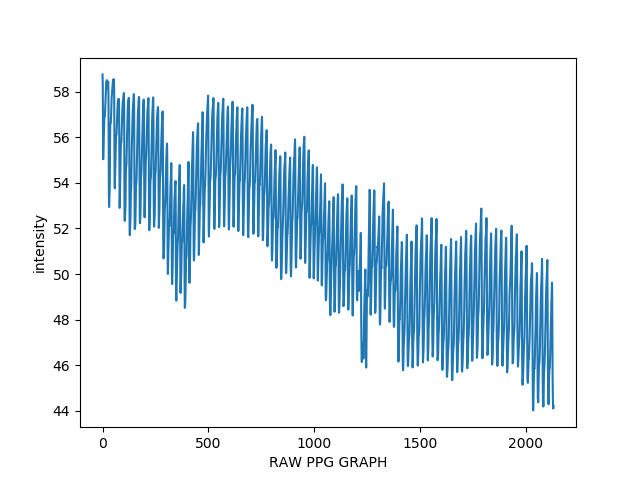

In [5]:
# Plot The PPG Graph
num=0
%matplotlib notebook
plt.plot(signal)
plt.xlabel('RAW PPG GRAPH')
plt.ylabel('intensity')
plt.show()

<IPython.core.display.Javascript object>


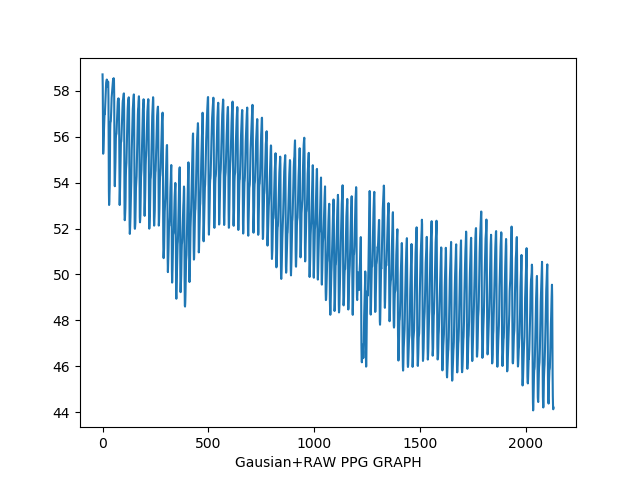

In [6]:
%matplotlib notebook
g_signal=gaussian_filter(signal,sigma=0.5,cval=0.5, truncate=4.0)

#plt.figure(figsize=(10,8))
plt.xlabel('Gausian+RAW PPG GRAPH')
plt.plot(g_signal)

In [19]:
# #plt.axis([700,750,50,60])
# plt.figure(figsize=(20,8))
# plt.plot(s_val)
# plt.xlabel('time_frames')
# plt.ylabel('intensity')
# plt.savefig(ck+".png")

(2133,)


<IPython.core.display.Javascript object>


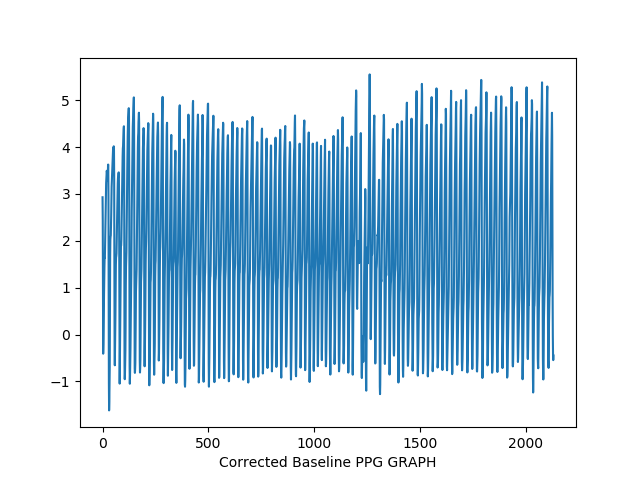

In [7]:
%matplotlib notebook
#correcting baseline
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

asx = g_signal.flatten()
print(asx.shape)
Corrected_base = asx-baseline_als(asx, 10000, 0.05)
plt.xlabel('Corrected Baseline PPG GRAPH')
plt.plot(Corrected_base)

<IPython.core.display.Javascript object>


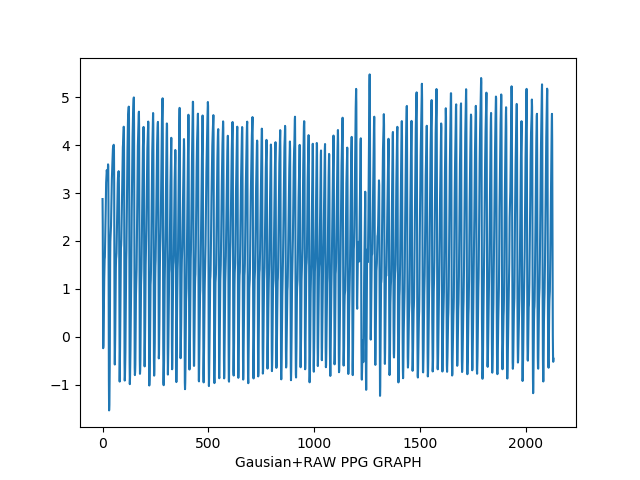

In [8]:
%matplotlib notebook
g_base_signal=gaussian_filter(Corrected_base,sigma=0.5,cval=0.5, truncate=5.0)

#plt.figure(figsize=(10,8))
plt.xlabel('Gausian+RAW PPG GRAPH')
plt.plot(g_base_signal)

<IPython.core.display.Javascript object>


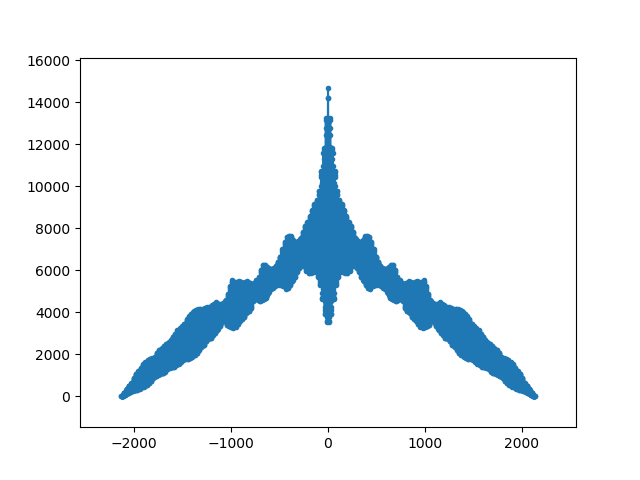

In [9]:
%matplotlib notebook
N = len(g_base_signal)
acorr = np.correlate(g_base_signal, g_base_signal, 'full')
plt.plot(np.arange(-N+1, N), acorr, '.-')
plt.margins(0.1, 0.1)
plt.show()

<IPython.core.display.Javascript object>


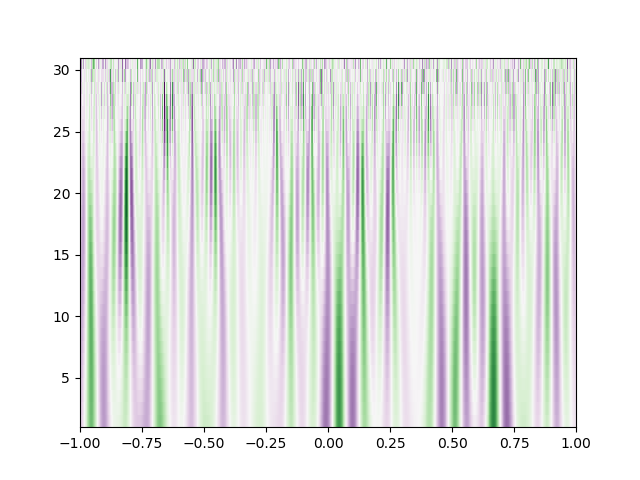

In [10]:
%matplotlib notebook
from scipy import signal
t = g_base_signal
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1, 31)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [12]:
x=g_base_signal

<IPython.core.display.Javascript object>


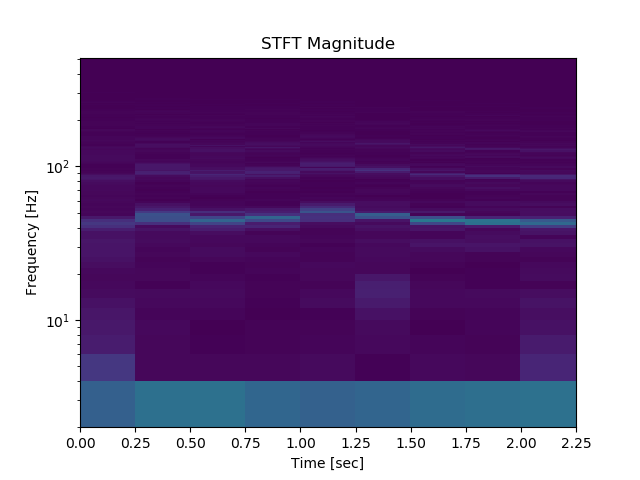

In [13]:
%matplotlib notebook
fs = 1024
N = 10*fs
nperseg = 512
amp = 2 * np.sqrt(2)
noise_power = 0.001 * fs / 2
time = np.arange(N) / float(fs)
carrier = amp * np.sin(2*np.pi*50*time)
noise = np.random.normal(scale=np.sqrt(noise_power),size=time.shape)
x = x 

#Compute the STFT, and plot its magnitude


f, t, Zxx = signal.stft(x, fs=fs, nperseg=nperseg)
plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.ylim([f[1], f[-1]])
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.show()

# Pick Finding Top picks Only

<IPython.core.display.Javascript object>


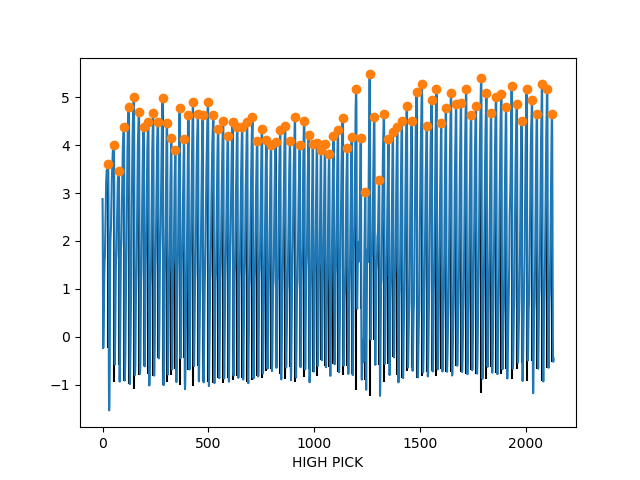

In [14]:
%matplotlib notebook

peaks, _= find_peaks(x, distance=15)
s_height = peak_prominences(x, peaks)[0]
contour_heights = x[peaks] - s_height

plt.xlabel('HIGH PICK')
plt.plot(x)
plt.plot(peaks, x[peaks], "o")
plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
plt.show()

In [15]:
#Features

contour_heights
s_height
peaks
pick_distance= np.diff(peaks)

<IPython.core.display.Javascript object>


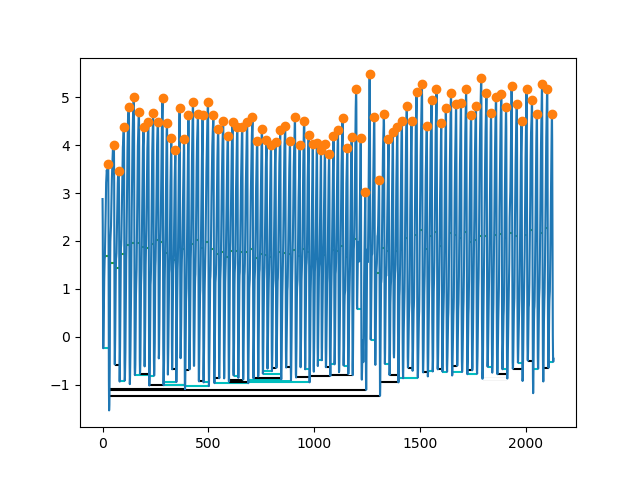

In [16]:
%matplotlib notebook
x=g_base_signal

results_half = peak_widths(x, peaks, rel_height=0.5)
results_full = peak_widths(x, peaks, rel_height=1)

plt.plot(x)
plt.plot(peaks, x[peaks], "o")
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C10")
plt.show()

In [17]:
#Features

len(results_full[0])

#results_half
#results_half*2

94

In [18]:
suhan=np.array(results_full)
suhan.shape


(4, 94)

<IPython.core.display.Javascript object>


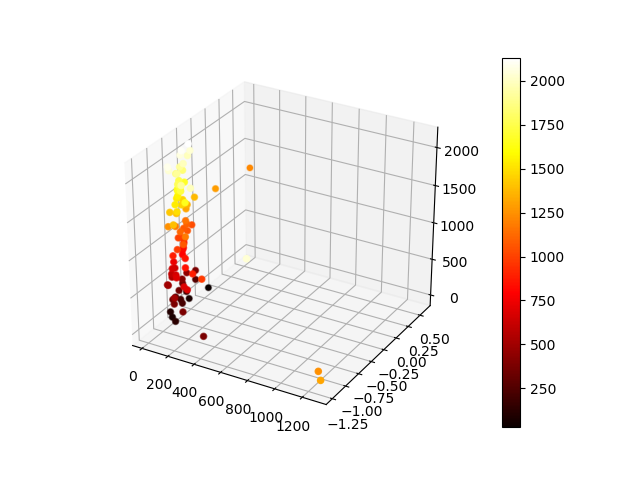

In [19]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = results_full[0]
y = results_full[1]
z = results_full[2]
c = results_full[3]

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

<IPython.core.display.Javascript object>


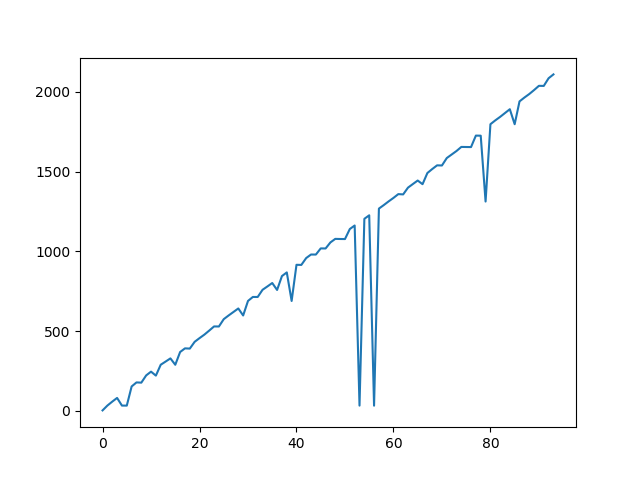

In [20]:
%matplotlib notebook
plt.plot(results_full[2])
plt.show() 

<IPython.core.display.Javascript object>


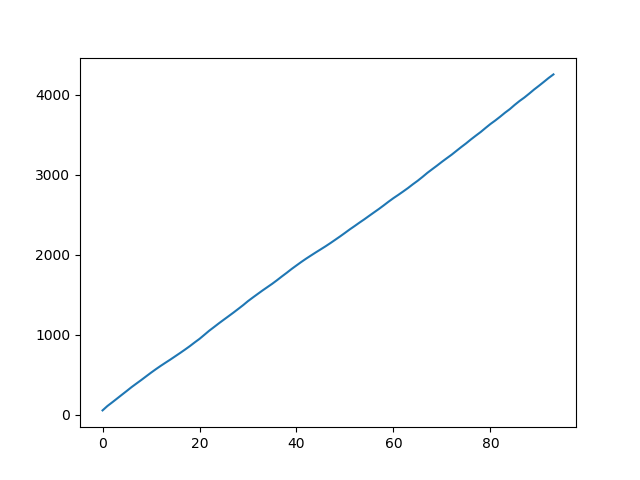

In [21]:
%matplotlib notebook
plt.plot(2*results_half[3])
plt.show()

F:\Anaconda\envs\tensorflow\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


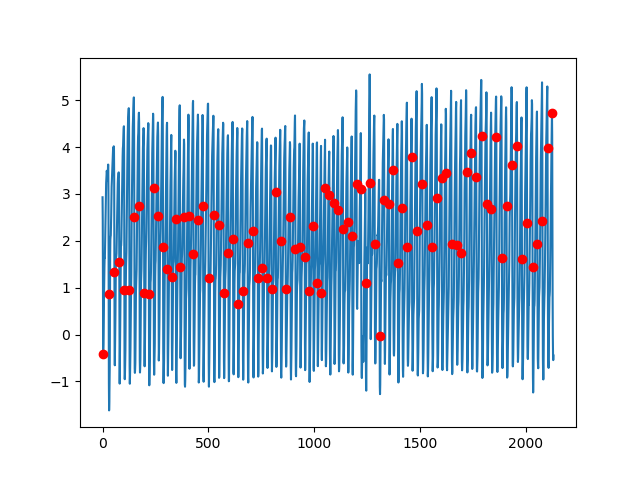

In [24]:
%matplotlib notebook
from scipy.signal import savgol_filter
window = 5
der2 = savgol_filter(Corrected_base, window_length=window,polyorder = 2,deriv=2)
max_der2 = np.max(np.abs(der2))
large = np.where(np.abs(der2) > max_der2/2)[0]
gaps = np.diff(large) > window
begins = np.insert(large[1:][gaps], 0, large[0])
ends = np.append(large[:-1][gaps], large[-1])
changes = ((begins+ends)/2).astype(np.int)

plt.plot(Corrected_base)
plt.plot(changes, Corrected_base[changes], 'ro')
plt.show()

In [23]:
%matplotlib notebook
plt.plot(der2)

NameError: name 'der2' is not defined

In [25]:
der2
max_der2
large
gaps
begins
ends
changes
Corrected_base[changes]

array([-0.40818561,  0.8562803 ,  1.32557108,  1.54033989,  0.9576986 ,
        0.94551331,  2.49701647,  2.74014676,  0.87967632,  0.8729528 ,
        3.13531864,  2.53653873,  1.8708227 ,  1.39262627,  1.23171754,
        2.47024816,  1.43772768,  2.51055986,  2.52611402,  1.71121641,
        2.44104918,  2.7484686 ,  1.1962595 ,  2.54710893,  2.33968863,
        0.87938208,  1.73541028,  2.03933533,  0.64959352,  0.93262823,
        1.94811962,  2.20514375,  1.2043343 ,  1.42337166,  1.2094069 ,
        0.96255684,  3.04886321,  2.00541313,  0.97829979,  2.50011427,
        1.81642096,  1.85941951,  1.64844079,  0.92215017,  2.3137702 ,
        1.10317533,  0.88375748,  3.1334341 ,  2.97693314,  2.80820525,
        2.65457259,  2.24233225,  2.40367585,  2.09322   ,  3.21588921,
        3.09566658,  1.10104994,  3.23664689,  1.93486775, -0.02492224,
        2.86665449,  2.77489744,  3.50297573,  1.53470625,  2.70490812,
        1.86585417,  3.79739667,  2.21647664,  3.21062334,  2.34

<IPython.core.display.Javascript object>


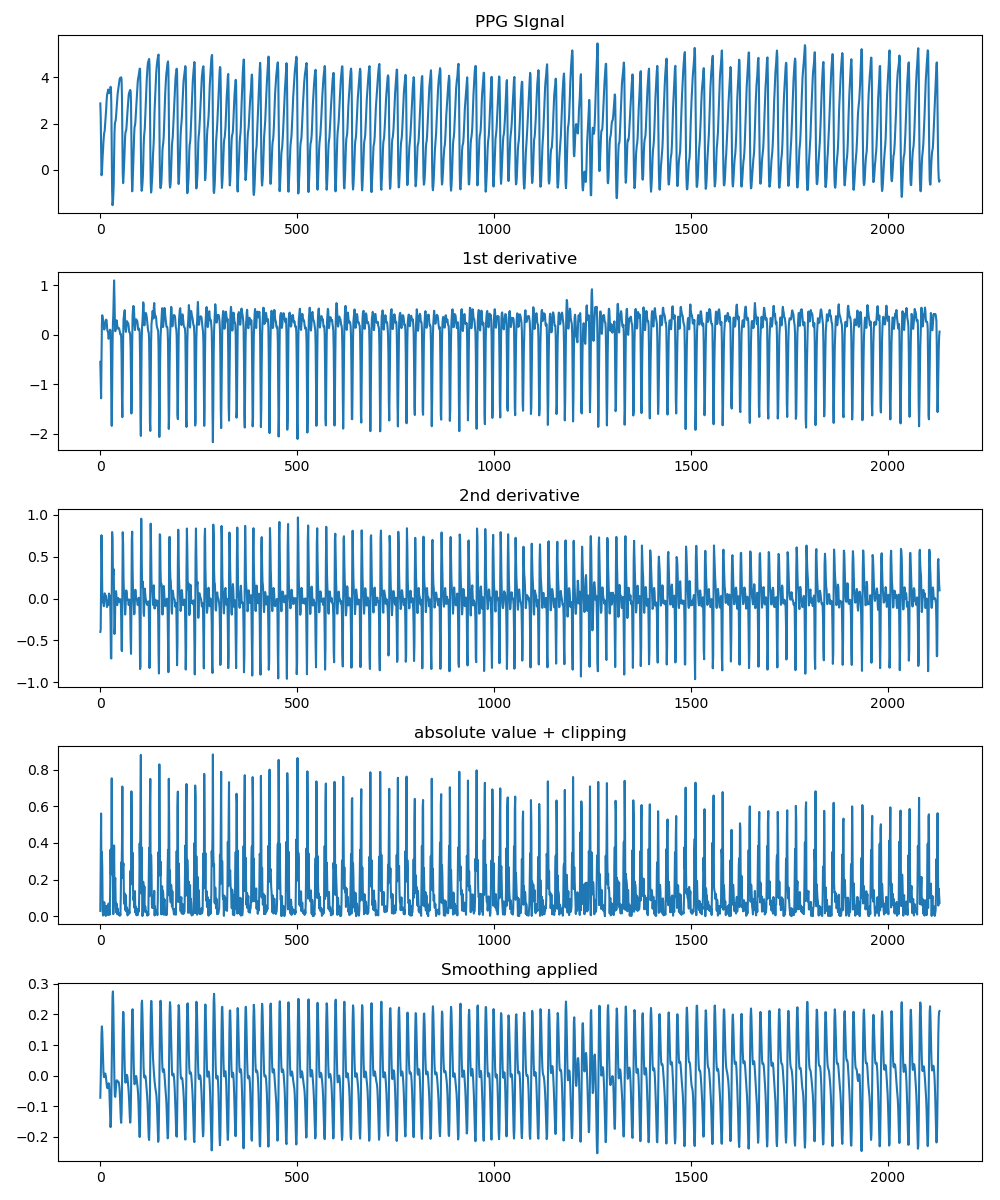

In [26]:
%matplotlib notebook

fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(5, 1) 

ax0 = plt.subplot(gs[0])
ax0.set_title('PPG SIgnal')
ax0.plot(g_base_signal)

base_signal_1stdev = np.gradient(g_base_signal)
ax1 = plt.subplot(gs[1])
ax1.set_title('1st derivative')
ax1.plot(base_signal_1stdev)

base_signal_2nddev = np.gradient(base_signal_1stdev)
ax2 = plt.subplot(gs[2])
ax2.set_title('2nd derivative')
ax2.plot(base_signal_2nddev)

base_signal_2nddev_clipped = np.clip(np.abs(np.gradient(base_signal_2nddev)), 0.0001, 10)
ax3 = plt.subplot(gs[3])
ax3.set_title('absolute value + clipping')
ax3.plot(base_signal_2nddev_clipped)

smoothed_signal = gaussian_filter1d(base_signal_2nddev, 2.4)
ax4 = plt.subplot(gs[4])
ax4.set_title('Smoothing applied')
ax4.plot(smoothed_signal)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


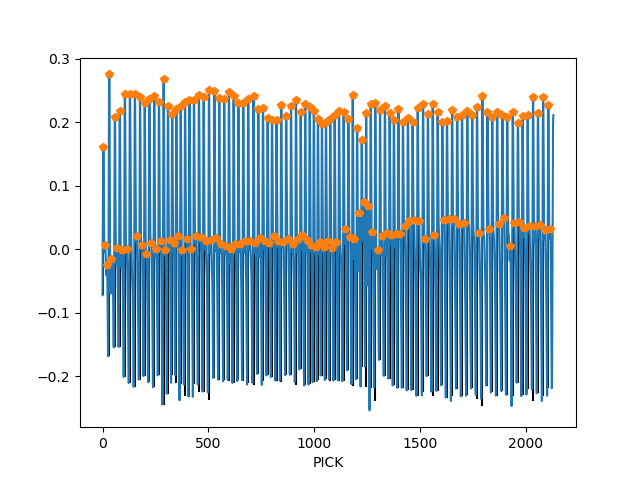

In [27]:
%matplotlib notebook

peaks2, _ = find_peaks(smoothed_signal, distance=1)
s_height2 = peak_prominences(smoothed_signal, peaks2)[0]
contour_heights2 = smoothed_signal[peaks2] - s_height2

plt.xlabel('PICK')
plt.plot(smoothed_signal)
plt.plot(peaks2, smoothed_signal[peaks2], "p")
plt.vlines(x=peaks2, ymin=contour_heights2, ymax=smoothed_signal[peaks2])
plt.show()

In [43]:
contour_heights
s_height
peaks
pick_distance= np.diff(peaks)

In [50]:
der2
max_der2
large
gaps
begins
ends
changes
Corrected_base[changes]

array([-0.40818561,  0.8562803 ,  1.32557108,  1.54033989,  0.9576986 ,
        0.94551331,  2.49701647,  2.74014676,  0.87967632,  0.8729528 ,
        3.13531864,  2.53653873,  1.8708227 ,  1.39262627,  1.23171754,
        2.47024816,  1.43772768,  2.51055986,  2.52611402,  1.71121641,
        2.44104918,  2.7484686 ,  1.1962595 ,  2.54710893,  2.33968863,
        0.87938208,  1.73541028,  2.03933533,  0.64959352,  0.93262823,
        1.94811962,  2.20514375,  1.2043343 ,  1.42337166,  1.2094069 ,
        0.96255684,  3.04886321,  2.00541313,  0.97829979,  2.50011427,
        1.81642096,  1.85941951,  1.64844079,  0.92215017,  2.3137702 ,
        1.10317533,  0.88375748,  3.1334341 ,  2.97693314,  2.80820525,
        2.65457259,  2.24233225,  2.40367585,  2.09322   ,  3.21588921,
        3.09566658,  1.10104994,  3.23664689,  1.93486775, -0.02492224,
        2.86665449,  2.77489744,  3.50297573,  1.53470625,  2.70490812,
        1.86585417,  3.79739667,  2.21647664,  3.21062334,  2.34

In [84]:
contour_heights2
s_height2
peaks2
pick_distance2= np.diff(peaks)

In [85]:
feature1 = []
feature2 =[]

In [117]:
feature1.append(contour_heights)
feature1.append(s_height)
feature1.append(pick_distance)
feature1.append(contour_heights2)
feature1.append(s_height2)
feature1.append(peaks2)
feature1.append(pick_distance2)

In [142]:
feature2.append(der2)
feature2.append(max_der2)
feature2.append(large)
feature2.append(begins)
feature2.append(ends)
feature2.append(changes)
feature2.append(Corrected_base[changes])

In [152]:
X1=np.asarray(feature1)
X2=np.asarray(feature2)
X.shape

(7,)

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X1+X2,y,test_size=0.2,random_state=0)

In [150]:
regressor=RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train,y_train)

In [148]:
from sklearn.svm import SVR

n_samples, n_features = X1, X2
rng = np.random.RandomState(0)
y =y
X = X1+X2
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X, y)
SVR(epsilon=0.2)